In [1]:
#Khai báo thư viện 
import os
import json
from dataclasses import dataclass
from typing import List, Optional, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             average_precision_score, precision_recall_curve, roc_curve)
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA

from sklearn import tree

try:
    import joblib
except Exception:
    joblib = None

# Optional: SMOTE
try:
    from imblearn.pipeline import Pipeline as ImbPipeline
    from imblearn.over_sampling import SMOTE
    IMB_AVAILABLE = True
except Exception:
    IMB_AVAILABLE = False


In [2]:
#Config
@dataclass
class Config:
    csv_path: str
    target_col: str
    categorical_cols: Optional[List[str]] = None
    test_size: float = 0.2
    random_state: int = 42
    n_splits: int = 5
    recall_target: float = 0.9
    cost_fn: float = 0.0
    cost_fp: float = 0.0
    use_smote: bool = False
    output_dir: str = "output_fraud"

def ensure_outdir(path: str):
    os.makedirs(path, exist_ok=True)

def sample_data_for_training(df: pd.DataFrame, target_col: str, n_total: int = 40000, target_fraud_ratio: float = 0.02, random_state: int = 42) -> pd.DataFrame:
    from sklearn.utils import shuffle
    df_pos = df[df[target_col] == 1]
    df_neg = df[df[target_col] == 0]
    n_pos = len(df_pos)
    n_neg_needed = int(n_pos * (1 - target_fraud_ratio) / target_fraud_ratio)
    n_neg_needed = min(n_neg_needed, len(df_neg))
    sampled_neg = df_neg.sample(n=n_neg_needed, random_state=random_state)
    sampled_df = pd.concat([df_pos, sampled_neg], axis=0)
    sampled_df = shuffle(sampled_df, random_state=random_state)
    print(f"[INFO] Sampled data: {len(sampled_df)} rows, fraud ratio={sampled_df[target_col].mean():.4f}")
    return sampled_df

def infer_column_types(X: pd.DataFrame, categorical_override: Optional[List[str]]=None) -> Tuple[List[str], List[str]]:
    cat_cols = [c for c in X.columns if str(X[c].dtype) in ("object", "category")]
    num_cols = [c for c in X.columns if c not in cat_cols]
    if categorical_override:
        override = [c for c in categorical_override if c in X.columns]
        cat_cols = sorted(list(set(cat_cols).union(set(override))))
        num_cols = [c for c in X.columns if c not in cat_cols]
    return num_cols, cat_cols


In [3]:
#Load CSV
def load_data_from_csv(cfg: Config) -> Tuple[pd.DataFrame, pd.Series]:
    if not os.path.isfile(cfg.csv_path):
        raise FileNotFoundError(f"File CSV không tồn tại: {cfg.csv_path}")
    df_full = pd.read_csv(cfg.csv_path)
    if cfg.target_col not in df_full.columns:
        raise ValueError(f"Không tìm thấy cột mục tiêu '{cfg.target_col}'")
    df = sample_data_for_training(df_full, cfg.target_col, random_state=cfg.random_state)
    y = df[cfg.target_col].astype(int)
    X = df.drop(columns=[cfg.target_col])
    print(f"[INFO] X shape={X.shape}, y shape={y.shape}")
    return X, y

cfg = Config(
    csv_path="creditcard.csv",
    target_col="Class",
    use_smote=True
)

ensure_outdir(cfg.output_dir)

X, y = load_data_from_csv(cfg)
X.head()


[INFO] Sampled data: 24599 rows, fraud ratio=0.0200
[INFO] X shape=(24599, 30), y shape=(24599,)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
271677,164687.0,2.062389,-0.074828,-1.067946,0.421706,-0.180512,-1.227995,0.159370,-0.314644,0.596467,...,-0.249206,-0.293201,-0.727193,0.346161,0.036251,-0.311787,0.196665,-0.073022,-0.060721,1.29
38388,39378.0,-0.973943,1.171064,0.907219,1.350711,0.251160,-0.015635,0.608004,0.431914,-1.702975,...,0.215936,0.240438,0.488302,-0.226887,0.048213,0.498952,-0.001601,-0.045287,-0.027964,55.63
12776,22408.0,1.186033,-0.294144,1.019719,-0.565865,-0.928925,-0.295884,-0.705442,0.002490,3.049365,...,-0.156687,-0.124689,0.164870,-0.008048,0.047003,0.411859,-0.697793,0.083593,0.028098,11.85
58343,48340.0,-0.963098,0.436865,1.546312,-0.427324,-0.216145,0.305129,-0.462414,0.814525,0.175287,...,-0.193991,0.077677,0.088889,-0.130590,-0.514570,-0.421735,0.130734,0.006896,0.036429,5.74
135391,81231.0,-0.582629,0.949019,-0.138487,-1.266682,2.410342,3.350199,0.110248,0.946798,-0.330953,...,0.343693,-0.312817,-0.925789,-0.048952,0.979691,0.015125,0.091090,0.374962,0.173924,3.56


In [4]:
#Tách train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=cfg.test_size, stratify=y, random_state=cfg.random_state
)
print(f"[INFO] X_train={X_train.shape}, X_test={X_test.shape}, positive_rate_train={y_train.mean():.4f}")


[INFO] X_train=(19679, 30), X_test=(4920, 30), positive_rate_train=0.0200


In [5]:
#Pipelines
def make_preprocessors(num_cols: List[str], cat_cols: List[str], for_svm: bool) -> ColumnTransformer:
    num_steps = [("imp", SimpleImputer(strategy="median"))]
    if for_svm:
        num_steps.append(("scaler", StandardScaler()))
    numeric = Pipeline(steps=num_steps)
    categorical = Pipeline(steps=[("imp", SimpleImputer(strategy="most_frequent")), 
                                  ("oh", OneHotEncoder(handle_unknown="ignore"))])
    pre = ColumnTransformer(transformers=[("num", numeric, num_cols), ("cat", categorical, cat_cols)])
    return pre

def build_pipelines(num_cols: list, cat_cols: list, cfg: Config):
    pre_tree = make_preprocessors(num_cols, cat_cols, for_svm=False)
    pre_svm = make_preprocessors(num_cols, cat_cols, for_svm=True)
    tree_clf = DecisionTreeClassifier(class_weight="balanced", random_state=cfg.random_state)
    svm_clf = SVC(kernel="rbf", probability=True, class_weight="balanced", random_state=cfg.random_state)
    if cfg.use_smote and IMB_AVAILABLE:
        smote_sampler = SMOTE(random_state=cfg.random_state)
        dt_pipe = ImbPipeline(steps=[("smote", smote_sampler), ("pre", pre_tree), ("clf", tree_clf)])
        svm_pipe = ImbPipeline(steps=[("smote", smote_sampler), ("pre", pre_svm), ("clf", svm_clf)])
    else:
        dt_pipe = Pipeline(steps=[("pre", pre_tree), ("clf", tree_clf)])
        svm_pipe = Pipeline(steps=[("pre", pre_svm), ("clf", svm_clf)])
    return dt_pipe, svm_pipe

num_cols, cat_cols = infer_column_types(X_train, cfg.categorical_cols)
print(f"[INFO] Numeric columns ({len(num_cols)}): {num_cols[:10]}{'...' if len(num_cols)>10 else ''}")
print(f"[INFO] Categorical columns ({len(cat_cols)}): {cat_cols[:10]}{'...' if len(cat_cols)>10 else ''}")

dt_pipe, svm_pipe = build_pipelines(num_cols, cat_cols, cfg)


[INFO] Numeric columns (30): ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9']...
[INFO] Categorical columns (0): []


In [6]:
#Hyperparameter tuning
dt_params = {
    "clf__max_depth": [None, 6, 10],
    "clf__min_samples_leaf": [1, 5, 20],
    "clf__min_samples_split": [2, 10, 50]
}
svm_params = {
    "clf__C": [0.5, 1, 2],
    "clf__gamma": ["scale", 0.1]
}

def tune_and_fit(pipe, params, X_train, y_train, cfg: Config, model_name: str):
    cv = StratifiedKFold(n_splits=cfg.n_splits, shuffle=True, random_state=cfg.random_state)
    gs = GridSearchCV(pipe, param_grid=params, scoring="average_precision", cv=cv, n_jobs=-1, verbose=1)
    gs.fit(X_train, y_train)
    print(f"[{model_name}] Best params:", gs.best_params_, "CV PR-AUC=", round(gs.best_score_, 4))
    return gs.best_estimator_

best_dt = tune_and_fit(dt_pipe, dt_params, X_train, y_train, cfg, "DecisionTree")
best_svm = tune_and_fit(svm_pipe, svm_params, X_train, y_train, cfg, "SVM_RBF")


Fitting 5 folds for each of 27 candidates, totalling 135 fits
[DecisionTree] Best params: {'clf__max_depth': 6, 'clf__min_samples_leaf': 20, 'clf__min_samples_split': 50} CV PR-AUC= 0.8358
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[SVM_RBF] Best params: {'clf__C': 2, 'clf__gamma': 'scale'} CV PR-AUC= 0.8334


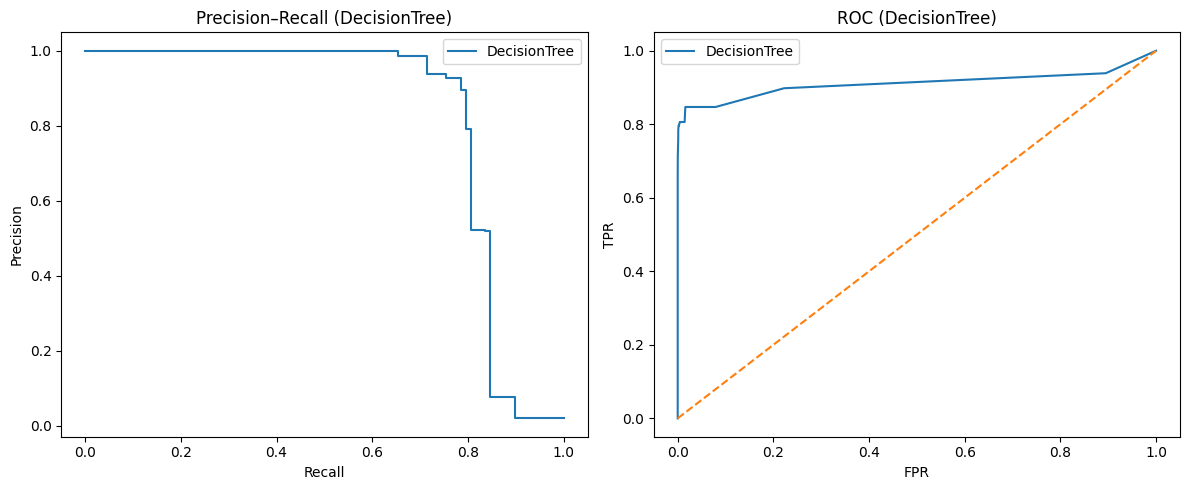

--- DecisionTree ---
ROC-AUC: 0.9108
PR-AUC: 0.8245
Confusion matrix (@0.5 threshold):
[[4623  199]
 [  15   83]]

Classification report:
              precision    recall  f1-score   support

           0     0.9968    0.9587    0.9774      4822
           1     0.2943    0.8469    0.4368        98

    accuracy                         0.9565      4920
   macro avg     0.6455    0.9028    0.7071      4920
weighted avg     0.9828    0.9565    0.9666      4920



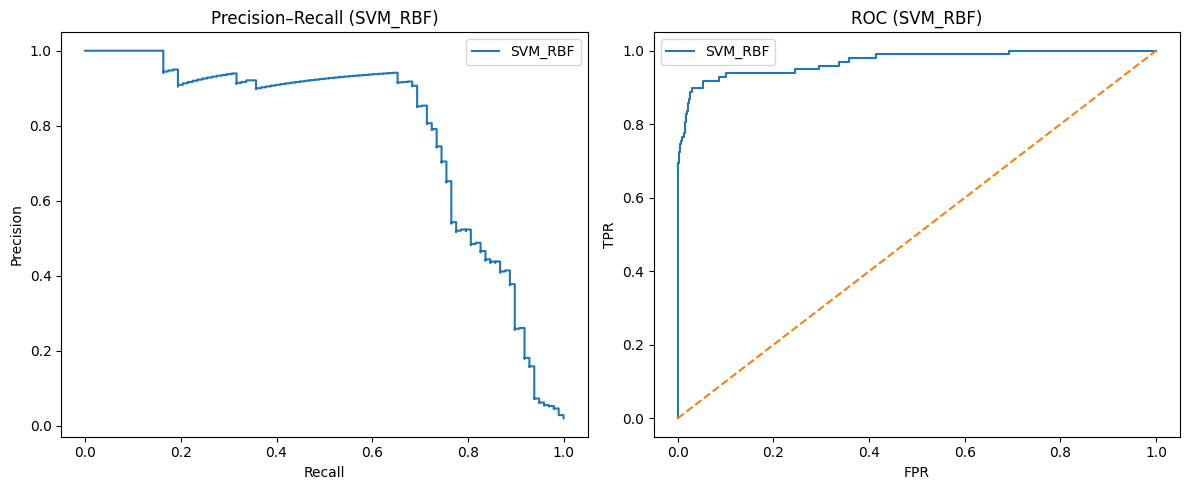

--- SVM_RBF ---
ROC-AUC: 0.9697
PR-AUC: 0.7830
Confusion matrix (@0.5 threshold):
[[4812   10]
 [  30   68]]

Classification report:
              precision    recall  f1-score   support

           0     0.9938    0.9979    0.9959      4822
           1     0.8718    0.6939    0.7727        98

    accuracy                         0.9919      4920
   macro avg     0.9328    0.8459    0.8843      4920
weighted avg     0.9914    0.9919    0.9914      4920



In [7]:
#Evaluate
def evaluate(model, X_test, y_test, name: str):
    proba = model.predict_proba(X_test)[:,1]
    pred_default = (proba >= 0.5).astype(int)
    
    roc = roc_auc_score(y_test, proba)
    prauc = average_precision_score(y_test, proba)
    cm = confusion_matrix(y_test, pred_default)
    report = classification_report(y_test, pred_default, digits=4)
    fig, axes = plt.subplots(1, 2, figsize=(12,5))

    # PR curve
    p, r, _ = precision_recall_curve(y_test, proba)
    axes[0].step(r, p, where="post", label=name)
    axes[0].set_xlabel("Recall")
    axes[0].set_ylabel("Precision")
    axes[0].set_title(f"Precision–Recall ({name})")
    axes[0].legend()

    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, proba)
    axes[1].plot(fpr, tpr, label=name)
    axes[1].plot([0,1],[0,1],"--")
    axes[1].set_xlabel("FPR")
    axes[1].set_ylabel("TPR")
    axes[1].set_title(f"ROC ({name})")
    axes[1].legend()

    plt.tight_layout()
    plt.show()
    
    
    print(f"--- {name} ---")
    print(f"ROC-AUC: {roc:.4f}")
    print(f"PR-AUC: {prauc:.4f}")
    print("Confusion matrix (@0.5 threshold):")
    print(cm)
    print("\nClassification report:")
    print(report)
    
    return proba

dt_proba = evaluate(best_dt, X_test, y_test, "DecisionTree")
svm_proba = evaluate(best_svm, X_test, y_test, "SVM_RBF")


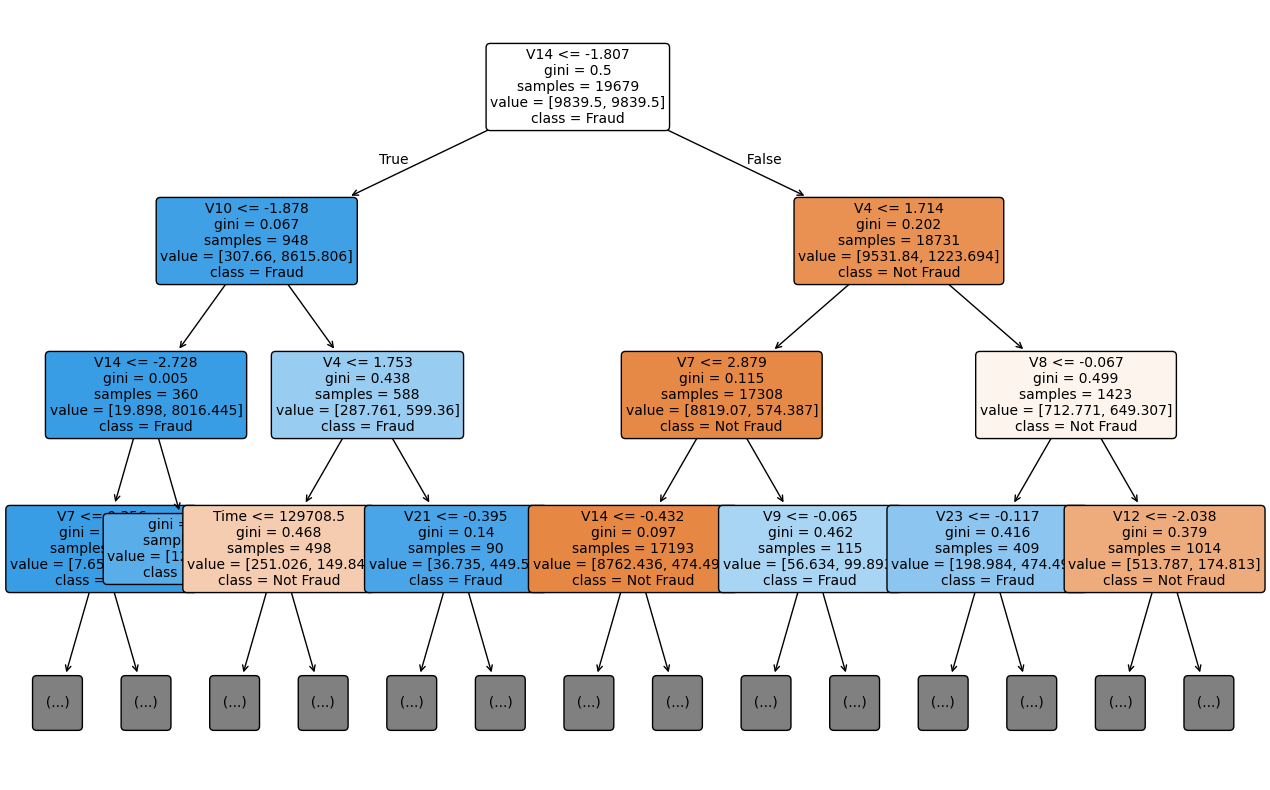

In [8]:
#Vẽ Decision Tree
def plot_decision_tree(dt_model, num_cols, cat_cols, max_depth=3):
    clf = dt_model.named_steps["clf"]
    plt.figure(figsize=(16,10))
    tree.plot_tree(
        clf, filled=True, rounded=True, feature_names=num_cols+cat_cols,
        class_names=["Not Fraud","Fraud"], max_depth=max_depth, fontsize=10
    )
    plt.show()

plot_decision_tree(best_dt, num_cols, cat_cols)

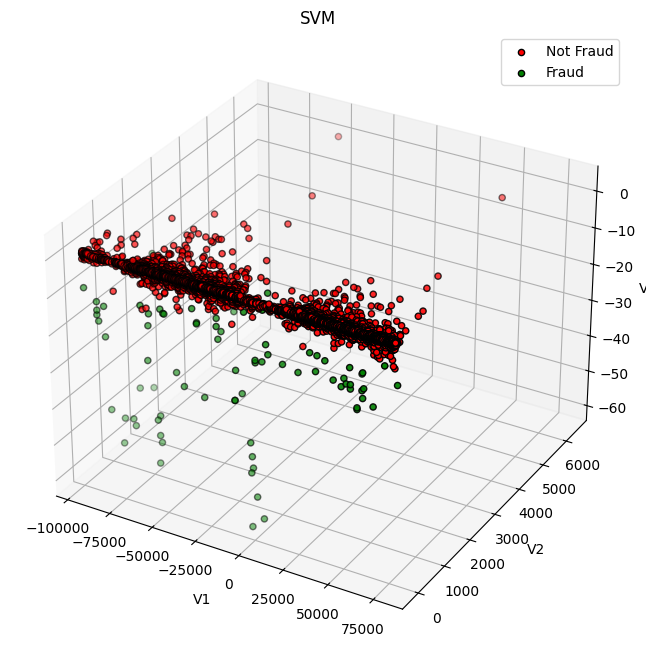

In [9]:
#Vẽ SVM RBF
def plot_svm(svm_model, X, y, n_components=3):
    y = np.array(y)
    if X.shape[1] > n_components:
        pca = PCA(n_components=n_components, random_state=42)
        X_plot = pca.fit_transform(X)
    else:
        X_plot = X[:,:n_components]
        pca = None

    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X_plot[y==0,0], X_plot[y==0,1], X_plot[y==0,2], c='red', label='Not Fraud', edgecolor='k')
    ax.scatter(X_plot[y==1,0], X_plot[y==1,1], X_plot[y==1,2], c='green', label='Fraud', edgecolor='k')
    ax.set_xlabel('V1'); ax.set_ylabel('V2'); ax.set_zlabel('V3')
    ax.set_title('SVM')
    ax.legend()
    plt.show()

plot_svm(best_svm, X_test.to_numpy(), y_test.to_numpy())

In [11]:
#Dự đoán trên 10k mẫu mới

df_full = pd.read_csv("creditcard.csv")
sample_df = df_full.sample(n=10000, random_state=cfg.random_state)

y_new = sample_df['Class'].astype(int)
X_new = sample_df.drop(columns=['Class'])

dt_pred_proba = best_dt.predict_proba(X_new)[:,1]
dt_pred_label = (dt_pred_proba >= 0.5).astype(int)

svm_pred_proba = best_svm.predict_proba(X_new)[:,1]
svm_pred_label = (svm_pred_proba >= 0.5).astype(int)


print(f"--- Dự đoán trên {len(sample_df)} mẫu mới ---")
for name, y_true, pred_label, pred_proba in [
    ("Decision Tree", y_new, dt_pred_label, dt_pred_proba),
    ("SVM RBF", y_new, svm_pred_label, svm_pred_proba)
]:
    cm = confusion_matrix(y_true, pred_label)
    roc = roc_auc_score(y_true, pred_proba)
    pr = average_precision_score(y_true, pred_proba)
    
    print(f"\n{name}:")
    print(f"- ROC-AUC: {roc:.4f}")
    print(f"- PR-AUC: {pr:.4f}")
    print("- Ma trận nhầm lẫn (confusion matrix) tại ngưỡng 0.5:")
    print(f"    TN = {cm[0,0]} (dự đoán đúng không gian lận)")
    print(f"    FP = {cm[0,1]} (dự đoán gian lận nhầm)")
    print(f"    FN = {cm[1,0]} (bỏ sót gian lận)")
    print(f"    TP = {cm[1,1]} (phát hiện đúng gian lận)")
    print(f"- Tổng số giao dịch gian lận thực tế: {y_true.sum()}")
    print(f"- Số giao dịch gian lận được mô hình phát hiện: {pred_label.sum()}")


--- Dự đoán trên 10000 mẫu mới ---

Decision Tree:
- ROC-AUC: 0.9947
- PR-AUC: 0.7461
- Ma trận nhầm lẫn (confusion matrix) tại ngưỡng 0.5:
    TN = 9593 (dự đoán đúng không gian lận)
    FP = 391 (dự đoán gian lận nhầm)
    FN = 1 (bỏ sót gian lận)
    TP = 15 (phát hiện đúng gian lận)
- Tổng số giao dịch gian lận thực tế: 16
- Số giao dịch gian lận được mô hình phát hiện: 406

SVM RBF:
- ROC-AUC: 0.9836
- PR-AUC: 0.7350
- Ma trận nhầm lẫn (confusion matrix) tại ngưỡng 0.5:
    TN = 9960 (dự đoán đúng không gian lận)
    FP = 24 (dự đoán gian lận nhầm)
    FN = 2 (bỏ sót gian lận)
    TP = 14 (phát hiện đúng gian lận)
- Tổng số giao dịch gian lận thực tế: 16
- Số giao dịch gian lận được mô hình phát hiện: 38
